## Цель данного проекта: поиск связей между людьми и организациями на основе новостной ленты

### В качестве примера была выбрана новостная лента Formula1

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import json
%matplotlib inline

plt.rcParams["figure.figsize"] = [15, 12]

Изначально планировалось использовать RSS канал для загрузки новостей, но как оказалось, большинство сайтов отдают по RSS новости за 1-2 дня, что делает выборку слишком маленькой.

Это допустимо, если собирать информацию долгое время, но для ускорения процесса был выбран вариант парсить телеграм-канал

In [ ]:
import asyncio
import logging
import random
import sys
from datetime import datetime, timedelta

import pytz
from telethon.sync import TelegramClient
from telethon.tl.functions.messages import GetHistoryRequest

In [ ]:
def init_logger():
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s | %(levelname)s\t| %(message)s')
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
logger = logging.getLogger()
init_logger()

### Сбор данных из канала

Для парсинга используется библиотека teleton. Она позволяет собирать новости из каналов, но имеет одну важную проблему: скорость работы.

Если совершать слишком много запросов с высокой частотой, УЗ будет забанена.

Поэтому новости выгружались 1 раз и сохранялись в json-файл.

In [ ]:
class MessageParser:
    def __init__(self, api_id, api_hash, phone, link):
        self.api_id = api_id
        self.api_hash = api_hash
        self.phone = phone
        self.link = link
        self.channel = None

        self.client = TelegramClient(phone, api_id, api_hash)
        self.client.start()

    async def init_client(self):
        await self.client.connect()
        self.channel = await self.client.get_entity(self.link)
        return self.channel

    @classmethod
    def get_text(cls, block: dict) -> str:
        text = None
        if 'text' in block:
            text = block.get('text')
        if 'texts' in block:
            text = block.get('texts')
        if text is None:
            return ''
        if isinstance(text, str):
            return text
        if isinstance(text, dict):
            return cls.get_text(text)
        if isinstance(text, list):
            data = [cls.get_text(x) for x in text]
            return ' '.join(data)
        return ''

    async def get_messages(self, date_from: datetime):
        all_messages = []
        offset_id = 0
        limit = 100
        utc = pytz.UTC
        target_date = datetime.now(tz=utc)

        while date_from < target_date:
            history = await self.client(GetHistoryRequest(
                peer=self.channel,
                offset_id=offset_id,
                offset_date=None,
                add_offset=0,
                limit=limit,
                max_id=0,
                min_id=0,
                hash=0
            ))
            if not history.messages:
                break
            target_date = min(list(map(lambda x: x.date, history.messages)))
            messages = list(filter(lambda x: x.date >= date_from, history.messages))
            for message in messages:
                all_messages.append(message.to_dict())
            offset_id = messages[len(messages) - 1].id
            logger.info(f'parsed {len(messages)} messages till {target_date.strftime("%d.%m.%Y")}')
            await asyncio.sleep(random.randint(200, 2000) / 1000)
        return all_messages

    def parse_message(self, message):
        media = message.get('media') or {}
        if isinstance(media, str):
            media = media.replace("'", '"')
            media = json.loads(media)
        webpage = media.get('webpage') or {}
        cached_page = webpage.get('cached_page') or {}
        blocks = cached_page.get('blocks') or []
        title = ' '.join([self.get_text(x) for x in blocks if x['_'] == 'PageBlockTitle'])
        data = ' '.join([self.get_text(x) for x in blocks if x['_'] == 'PageBlockParagraph'])
        date = message['date'].isoformat()
        return {'title': title, 'text': data, 'date': date}

    async def close(self):
        return await self.client.disconnect()

    async def __aenter__(self):
        await self.init_client()
        return self

    async def __aexit__(self, exc_type, exc_val, exc_tb):
        await self.close()


In [ ]:
utc = pytz.UTC
async with MessageParser(
        api_id=...,
        api_hash='...',
        phone='...',
        link='https://t.me/formula_1_news'
) as parser:
    date_from = datetime.now(tz=utc) - timedelta(days=365)
    all_messages = await parser.get_messages(date_from)

    msg_data = []
    for message in all_messages:
        data = parser.parse_message(message)
        msg_data.append(data)

In [ ]:
with open('messages.json', 'w+') as outfile:
    json.dump(msg_data, outfile, ensure_ascii=False, indent=4)

## Обработка языковой моделью

Для поиска имен и названий организаций, была использована модель Наташа.

В идеале, хотелось бы обучить свою модель под конкретный вид новостей, но времени на разметку датасета не хватило.

In [ ]:
from natasha import (
    Segmenter,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,

    NewsNERTagger,
    MorphVocab,

    Doc
)

In [ ]:
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
morph_vocab = MorphVocab()

Далее идут классы Тега и Новости. Они позволяют немного унифицировать формат получаемых новостей

In [ ]:
from dataclasses import dataclass, asdict


@dataclass(frozen=True)
class Tag(object):
    data: str
    type: str

    dict = asdict

In [ ]:
class News:
    def __init__(self, item=None) -> None:
        self.title = ''
        self.content = ''
        self.tags = set()
        if item is not None:
            if isinstance(item, dict):
                self.title = item.get('title')
                self.content = item.get('text') or item.get('content')
            else:
                self.title = item.title.content
                self.content = item.description.content

    @property
    def full_text(self) -> str:
        title = self.title.replace(':', '.')
        return f'{title}.\n{self.content}'

    @property
    def short_text(self) -> str:
        return f'title: {self.title}'

    def to_dict(self):
        return {
            'title': self.title,
            'content': self.content,
            'tags': [x.dict() for x in self.tags]
        }


Для ускорения повторного запуска ноутбука, данные можно подгрузить здесь из локального файла 

In [57]:
if len(msg_data) == 0:
    with open('data.json', 'r') as data_file:
        msg_data = json.load(data_file)
        for item in data:
            print(f'title: {item.title}')
            print(f'tags: {", ".join([x.data for x in item.tags])}')
            print('------')

title: Джеймс Ваулз о причинах увольнения Сарджента
tags: Логан Сарджент, Williams, Зандфорт, Джеймс Ваулз, Монце, Логан, Сарджент
------
title: Гран При Италии: Элементы силовых установок
tags: FIA, Монце, Италия
------
title: Хельмут Марко: Проблем не было только у McLaren
tags: McLaren, Кристиан Хорнера, Зандфорт, Kronen Zeitung, Red Bull Racing, Йос, Зандворт, Red Bull, Хельмут Марко, Монце, Mercedes, Кристиан, Макс Ферстаппен
------
title: Джордан: Ньюи интересуют не только деньги
tags: Ферстаппена, McLaren, Williams, Formula For Success, Зандфорт, Эдди Джордан, Эдриан, Red Bull, Ландо Норрис, Leyton House, Эдриан Ньюи
------
title: Австралийский промоутер оштрафован за отмену концерта
tags: Клайд Крофт, Гран При, Робби Уильямс, Австралия, Эндрю Уэстакотт, Альберт-парк, Australian Grand Prix Corporation (AGPC), AGPC, Промоутер Гран, Виктория, World Touring Melbourne, Робби Уильмс, Мельбурн, Верховный суд
------
title: В Ferrari подготовили новинки специально для Монцы
tags: Фредер

Данные переводятся в формат объектов и прогоняются через языковую модель

In [58]:
data = [News(item) for item in msg_data]

In [297]:
for item in data:
    item.tags = set()
    doc = Doc(item.full_text)
    logger.debug(f'parsed {item.full_text[:50]}...')
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)

    ner_tagger = NewsNERTagger(emb)
    doc.tag_ner(ner_tagger)

    for span in doc.spans:
        if span.type in ('PER', 'ORG'):
            span.normalize(morph_vocab)
            tag = Tag(data=span.normal, type=span.type)
            item.tags.add(tag)


Так как языковая модель на таком количестве данных работает небыстро, промежуточные данные так же сохраняются в файл.

In [583]:
with open('data.json', 'w+') as data_file:
    raw_data = [x.to_dict() for x in data]
    json.dump(raw_data, data_file, ensure_ascii=False)

### Обработка графовой моделью

Для упрощения проверок, весь код модели был объединен в один класс.

Исходя из анализа, в чистых новостях присутствует много шумов: объектов, которые появляются единичное количество раз. 

Такие шумы искусственно удаляются за счет введения порогового значения необходимого количества связей каждого узла.

Как можно заметить ниже из графиков, при разных пороговых значениях, граф выделяет разные подграфы и сообщества. 

Например, небольшие сообщества (в данном случае, команды) отдично видны на небольших порогах, но полностью отфильтровываются высокими. Так же и наоборот, при небольших порогах, крупные сообщества/команды определяются как один граф и одно сообщество. Однако при повышении лимита, между ними видна разница

In [570]:
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms import community

In [580]:
from typing import Dict
from itertools import combinations
import json

class Graph:
    def __init__(self, source_data):
        self.source_data = source_data
        self.mapping = {}
        self.tags = [x.data for key in self.source_data for x in key.tags]
        self.nodes = {key: self.tags.index(key) for key in self.tags}
        self.reverse_nodes = {i: key for i, key in enumerate(self.tags)}
        
        self.make_links()
        ...

    def mean_link_val(self):
        sum = 0
        count = 0
        for first, row in self.mapping.items():
            for second, val in row.items():
                sum += val
                count += 1
        return sum / count
    
    def _add_link_value(self, first, second):
        if first not in self.mapping:
            self.mapping[first] = {}
        if second not in self.mapping[first]:
            self.mapping[first][second] = 0
        self.mapping[first][second] += 1
    
    def make_links(self):        
        for item in self.source_data:
            tags = [x.data for x in item.tags]
            combs = list(combinations(tags, 2))
            for unit in combs:
                self._add_link_value(unit[0], unit[1])
                self._add_link_value(unit[1], unit[0])
        return self.mapping
    
    def make_interactions(self, limit_k: int = 1):
        mapping = self.mapping.copy()
        mean_val = self.mean_link_val()
        
        limit_val = limit_k * mean_val
        
        links = []
        mapping = self.filter_mapping(lambda x: x > limit_val, mapping)
        
        for first, row in mapping.items():
            for second, val in row.items():
                if first in mapping and second in mapping:
                    links.append({'source': self.nodes[first], 'target': self.nodes[second], 'value': val/limit_val})
        
        nodes = [{'name': k, 'id': v} for k, v in self.nodes.items() if k in mapping]
        
        return {
            'nodes': nodes,
            'links': links,
            'directed': False,
            'graph': {},
        }

    def filter_mapping(self, key, source: Dict[str, Dict[str, int]]):
        result = {}
        for first, row in source.items():
            for second, val in row.items():
                if key(val):
                    if first not in result:
                        result[first] = {}
                    result[first][second] = val
        return result


    def reduce_mapping(self, func, source: Dict[str, Dict[str, int]]):
        result = source.copy()
        for first, row in source.items():
            for second, val in row.items():
                if first not in result:
                    result[first] = {}
                result[first][second] = func(val)
        return result
    
    def make_nx_graph(self, limit_k: int = 1):
        interactions = self.make_interactions(limit_k)
        return json_graph.node_link_graph(interactions)
    
    def get_communities_with_limit(self, limit_k: int = 1):
        graph = self.make_nx_graph(limit_k)
        communities_generator = community.girvan_newman(graph)
        next_level_communities = next(communities_generator)
        communities = sorted(map(sorted, next_level_communities))
        return list(communities)
    
    def get_all_communities(self, limit_from: int = 0, limit_to: int = None, step: int = 1):
        communities = self.get_communities_with_limit(limit_from)
        result = []
        limit = limit_from
        while len(communities) > 0 or (limit_to is not None and limit_from < limit_to):
            communities = self.get_communities_with_limit(limit)
            logger.info(f'limit: {limit}; additional communities: {len(communities)}')
            add_communities = list(filter(lambda x: 1 < len(x) < 5, communities))
            for c in add_communities:
                if c not in result:
                    result.append(c)
            limit += step
        return result
    
    def draw_graph(self, limit_k: int = 1):
        graph = self.make_nx_graph(limit_k)
        nx.draw_spring(
            graph,
            with_labels=True,
            alpha=0.7,
            labels={n[0]: n[1]['name'] for n in graph.nodes.data()}
        )
    
    def print_community(self, community):
        print('Community: ', ', '.join([self.tags[n] for n in community]))

# print(json.dumps(interactions, ensure_ascii=False))

In [581]:
my_graph = Graph(data)

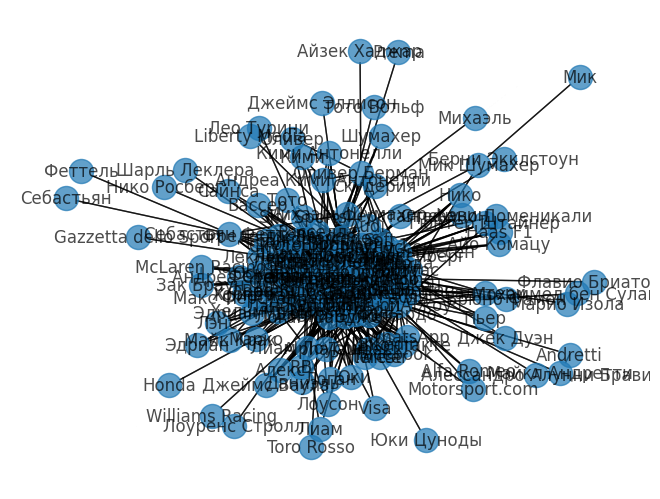

In [575]:
my_graph.draw_graph(10)

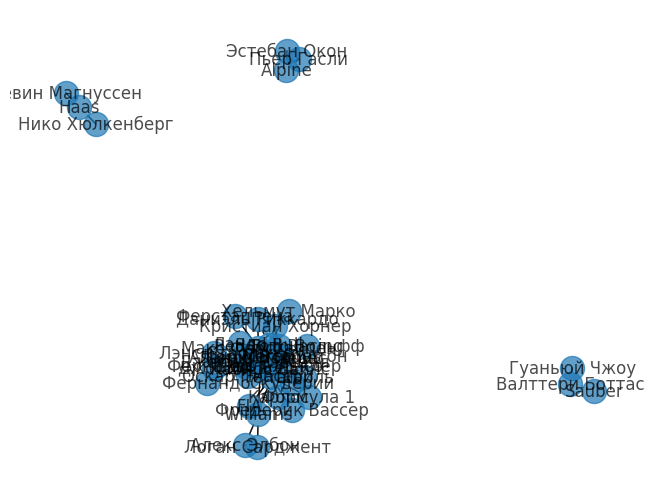

In [576]:
my_graph.draw_graph(50)

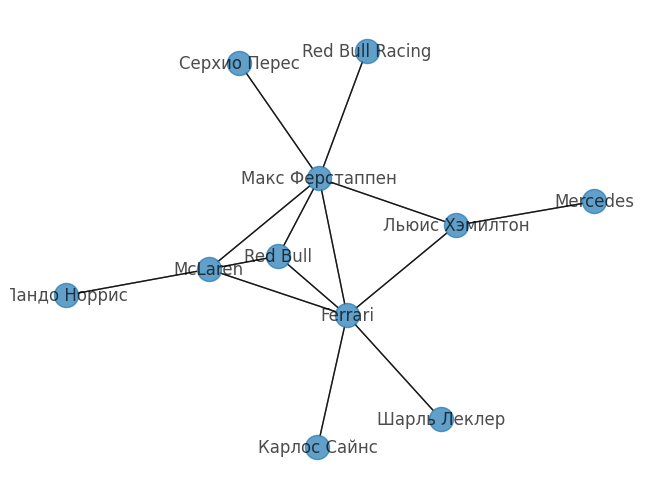

In [577]:
my_graph.draw_graph(150)

Исходя из такой особенности, был написан алгоритм поиска сообществ в подобном графе.

Он основывается на алгоритме `girvan_newman`, но выполняет поиск небольших (до 5 включений) сообществ на разных масштабах пороговых значений. Таким образом, находятся сообщества с различной упоминаемостью в новостях

In [582]:
communities = my_graph.get_all_communities(limit_from=10, step=10)


2024-08-30 19:00:04,543 | INFO	| limit: 10; additional communities: 2
2024-08-30 19:00:04,591 | INFO	| limit: 20; additional communities: 3
2024-08-30 19:00:04,646 | INFO	| limit: 30; additional communities: 4
2024-08-30 19:00:04,673 | INFO	| limit: 40; additional communities: 4
2024-08-30 19:00:04,700 | INFO	| limit: 50; additional communities: 5
2024-08-30 19:00:04,722 | INFO	| limit: 60; additional communities: 3
2024-08-30 19:00:04,744 | INFO	| limit: 70; additional communities: 3
2024-08-30 19:00:04,767 | INFO	| limit: 80; additional communities: 3
2024-08-30 19:00:04,791 | INFO	| limit: 90; additional communities: 4
2024-08-30 19:00:04,814 | INFO	| limit: 100; additional communities: 3
2024-08-30 19:00:04,836 | INFO	| limit: 110; additional communities: 2
2024-08-30 19:00:04,859 | INFO	| limit: 120; additional communities: 2
2024-08-30 19:00:04,878 | INFO	| limit: 130; additional communities: 2
2024-08-30 19:00:04,897 | INFO	| limit: 140; additional communities: 2
2024-08-30 19:0

Как видно, на разных масштабах находятся разные сообщества.

Интересно было бы выполнить автоматическую подборку лимитов или прогрессивную шкалу весов для связей, но это сделать я не успел :(

In [578]:
for x in communities:
    my_graph.print_community(x)

Community:  Мик Шумахер, Мик
Community:  Логан Сарджент, Алекс Элбон, Алекс
Community:  Валттери Боттас, Sauber, Гуаньюй Чжоу
Community:  Alpine, Эстебан Окон, Пьер Гасли
Community:  Haas, Нико Хюлкенберг, Кевин Магнуссен
Community:  Логан Сарджент, Williams, Алекс Элбон
Community:  Williams, Алекс Элбон
Community:  Aston Martin, Фернандо Алонсо
Community:  Ландо Норрис, Оскар Пиастри
Community:  Mercedes, Джордж Расселл, Льюис Хэмилтон
Community:  McLaren, Ландо Норрис
Community:  Red Bull, Макс Ферстаппен, Серхио Перес
Community:  Mercedes, Льюис Хэмилтон
Community:  Ferrari, Шарль Леклер, Карлос Сайнс
Community:  Red Bull, Макс Ферстаппен
Community:  Ferrari, Карлос Сайнс


Как можно заметить, в итоговой выборке проскакивают вбросы (из низких значений лимита), а так же некоторое количество дублей.

В данном случае, это не критично. Практически все реальные сообщества и команды, находившиеся в выборке, присутствуют.

Можно было так же поэкспериментировать с шагом и начальным значением, для улучшения результата. Однако основная цель была достигнута.